For this project, we created a reproducible workflow to help us iterate over ideas and continue to improve the accuracy of our predictions for the Kaggle competition: Titanic - Machine Learning from Disaster. The details of the competition and of the dataset are available [here](https://www.kaggle.com/c/titanic/data) 

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [159]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Initial Data Cleaning

In [160]:
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [161]:
def pre_process(df):
    """Pre process the df by applying all of the above functions

    Usage
    ------

    train = pre_process(train)
    """
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    cols = ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"]
    for col in cols:
        df = create_dummies(df,col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 891 non-null    int64   
 1   Survived                    891 non-null    int64   
 2   Pclass                      891 non-null    int64   
 3   Name                        891 non-null    object  
 4   Sex                         891 non-null    object  
 5   Age                         891 non-null    float64 
 6   SibSp                       891 non-null    int64   
 7   Parch                       891 non-null    int64   
 8   Ticket                      891 non-null    object  
 9   Fare                        891 non-null    float64 
 10  Embarked                    891 non-null    object  
 11  Age_categories              891 non-null    category
 12  Fare_categories             891 non-null    category
 13  Title               

First, we're going to examine the two columns that contain information about the family members each passenger had onboard: SibSp and Parch.

In [162]:
train['Family_size'] = train['Parch'] + train['SibSp']
cols = ['SibSp', 'Parch', 'Survived', 'Family_size']
train[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   SibSp        891 non-null    int64
 1   Parch        891 non-null    int64
 2   Survived     891 non-null    int64
 3   Family_size  891 non-null    int64
dtypes: int64(4)
memory usage: 28.0 KB


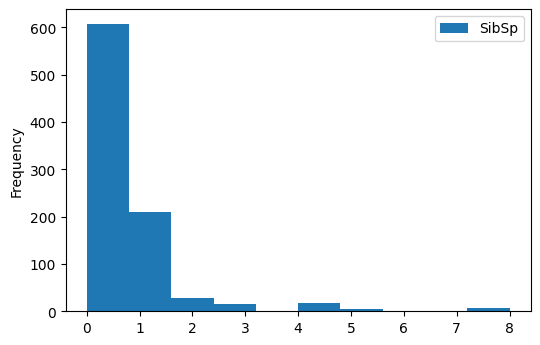

In [163]:
train['SibSp'].plot.hist()
plt.legend()
plt.show()

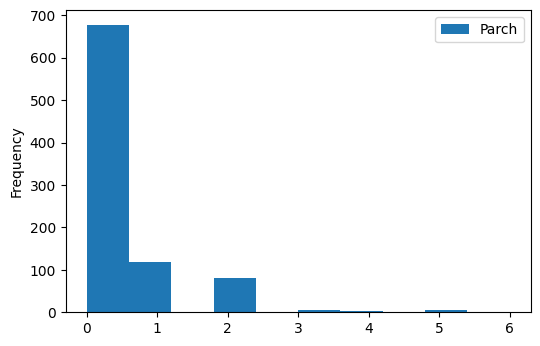

In [164]:
train['Parch'].plot.hist()
plt.legend()
plt.show()

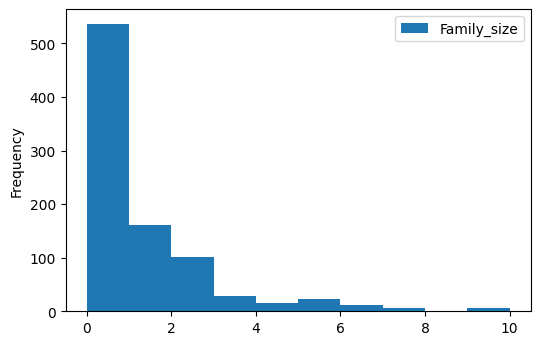

In [165]:
train['Family_size'] = train['Parch'] + train['SibSp']
train['Family_size'].plot.hist()
plt.legend()
plt.show()

In [166]:
pivot = pd.pivot_table(train, index='Family_size', values = 'Survived')
pivot

,Survived
Family_size,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


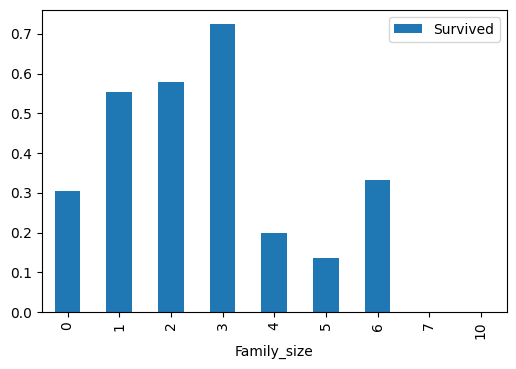

In [167]:
pivot.plot.bar()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. We sum these two columns to creat the Famili_size column that shows the total number of family members each passenger had onboard. All of these columns has any missing values.

The distribution of values in all columns is skewed right, the SibSp and Parch columns has the majority of values being zero however the Famili_size column has less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived (only about 30%), while greater numbers of passengers with family members survived. 

## Features Engineers

In [168]:
def process_isalone(df):
    """Create a new feture to tract whether the passengers have other famliy member or not

    Usage
    ------

    train = process_isalone(train)
    """
    df['Family_size'] = df['Parch'] + df['SibSp']
    df['isalone'] = 0
    df.loc[df['Family_size'] == 0, 'isalone'] = 1       
    return df

In [169]:
train = process_isalone(train)
holdout = process_isalone(holdout)

## Features Selection

In [170]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['PassengerId', 'Survived'], axis = 1)
    all_y = df['Survived']
    model = RandomForestClassifier(random_state=1)
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))    
    return best_columns       

In [171]:
features = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Family_size']



## Model Selection

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        grid = GridSearchCV(model['estimator'], param_grid= model["hyperparameters"], cv = 10)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
    return models

In [174]:
result = select_model(train,features)

LogisticRegression
------------------


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

Best Score: 0.821598002496879
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.7822971285892635
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8350686641697876
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}



## Making a Submission to Kaggle

In [177]:
def save_submission_file(model, features, filename="submission.csv"):
    predictions = model.predict(holdout[features]) 
    holdout_ids = holdout["PassengerId"]
    submission = {'PassengerID' : holdout_ids, 'Survived': predictions}
    submission = pd.DataFrame(submission)
    submission.to_csv(filename,index=False)

best_model = result[2]['best_model']
save_submission_file(best_model, features, filename="submission.csv")